In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import numpy as np 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import random

sns.set_context('notebook',font_scale=1.5)


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Mercari/p1_train.csv')

In [ ]:
data.head()

,Unnamed: 0,train_id,name,item_condition_id,brand_name,price_x_x_x,shipping,item_description,category_main,category_sub1,category_sub2,brand_name_count,"('price', 'mean')_x","('price_y', 'mean')",shipping_count,"('price_x', 'mean')_x",category_main_count,"('price_x_y', 'mean')",category_sub1_count,"('price_x_x', 'mean')_x",category_sub2_count,"('price_x_x_y', 'mean')"
0,0,0,MLB Cincinnati Reds T Shirt Size XL,3,uknown,10.0,1,No description yet,Men,Tops,T-shirts,8553,20.537180,26.092650,8948,21.731001,1258,35.191574,318,18.921384,229,17.471616
1,1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3,37.000000,26.092650,11008,29.821403,1610,32.832919,49,71.551020,13,50.153846
2,2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,22,18.090909,26.136259,8948,21.731001,8895,28.358572,1385,17.555235,279,15.516129
3,3,3,Leather Horse Statues,1,uknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,8553,20.537180,26.136259,8948,21.731001,846,24.395981,318,22.235849,163,22.429448
4,4,4,24K GOLD plated rose,1,uknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,8553,20.537180,26.136259,11008,29.821403,8895,28.358572,858,25.737762,276,24.449275


In [ ]:
data = data.iloc[: , 1:]

#### text feature engineering

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 1500000000 #or any large value, as long as you don't run out of RAM

#### Creating some underlined features before data cleaning

#### word count

In [ ]:
data['word_count'] = [len(i.split()) for i in data['item_description']]
data.head(2)

,train_id,name,item_condition_id,brand_name,price_x_x_x,shipping,item_description,category_main,category_sub1,category_sub2,brand_name_count,"('price', 'mean')_x","('price_y', 'mean')",shipping_count,"('price_x', 'mean')_x",category_main_count,"('price_x_y', 'mean')",category_sub1_count,"('price_x_x', 'mean')_x",category_sub2_count,"('price_x_x_y', 'mean')",word_count
0,0,MLB Cincinnati Reds T Shirt Size XL,3,uknown,10.0,1,No description yet,Men,Tops,T-shirts,8553,20.537180,26.092650,8948,21.731001,1258,35.191574,318,18.921384,229,17.471616,3
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3,37.000000,26.092650,11008,29.821403,1610,32.832919,49,71.551020,13,50.153846,36
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,22,18.090909,26.136259,8948,21.731001,8895,28.358572,1385,17.555235,279,15.516129,29
3,3,Leather Horse Statues,1,uknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,8553,20.537180,26.136259,8948,21.731001,846,24.395981,318,22.235849,163,22.429448,32
4,4,24K GOLD plated rose,1,uknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,8553,20.537180,26.136259,11008,29.821403,8895,28.358572,858,25.737762,276,24.449275,5


In [ ]:
data['word_count'].describe()

count    19956.00000
mean        25.76809
std         30.41442
min          1.00000
25%          7.00000
50%         15.00000
75%         31.00000
max        222.00000
Name: word_count, dtype: float64

#### stopword count

In [ ]:
def stopword(text):

  doc = nlp(text)

  count = 0
  for token in doc:
    if token.is_stop==True:
      count += 1
  return count

In [ ]:
data['stopword_count'] = data['item_description'].apply(stopword)

In [ ]:
data.head()

,train_id,name,item_condition_id,brand_name,price_x_x_x,shipping,item_description,category_main,category_sub1,category_sub2,brand_name_count,"('price', 'mean')_x","('price_y', 'mean')",shipping_count,"('price_x', 'mean')_x",category_main_count,"('price_x_y', 'mean')",category_sub1_count,"('price_x_x', 'mean')_x",category_sub2_count,"('price_x_x_y', 'mean')",word_count,stopword_count
0,0,MLB Cincinnati Reds T Shirt Size XL,3,uknown,10.0,1,No description yet,Men,Tops,T-shirts,8553,20.537180,26.092650,8948,21.731001,1258,35.191574,318,18.921384,229,17.471616,3,2
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3,37.000000,26.092650,11008,29.821403,1610,32.832919,49,71.551020,13,50.153846,36,19
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,22,18.090909,26.136259,8948,21.731001,8895,28.358572,1385,17.555235,279,15.516129,29,18
3,3,Leather Horse Statues,1,uknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,8553,20.537180,26.136259,8948,21.731001,846,24.395981,318,22.235849,163,22.429448,32,15
4,4,24K GOLD plated rose,1,uknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,8553,20.537180,26.136259,11008,29.821403,8895,28.358572,858,25.737762,276,24.449275,5,2


In [ ]:
data['stopword_count'].describe()

count    19956.000000
mean         9.133544
std         12.793809
min          0.000000
25%          2.000000
50%          4.000000
75%         11.000000
max        130.000000
Name: stopword_count, dtype: float64

#### name entity recognition count

In [ ]:
def ner(text):

  doc = nlp(text)

  count = 0

  for ent in doc.ents:
    if ent.label_:
      count += 1
  return count 

In [ ]:
data['ner'] = data['item_description'].apply(ner)

In [ ]:
data.head()

,train_id,name,item_condition_id,brand_name,price_x_x_x,shipping,item_description,category_main,category_sub1,category_sub2,brand_name_count,"('price', 'mean')_x","('price_y', 'mean')",shipping_count,"('price_x', 'mean')_x",category_main_count,"('price_x_y', 'mean')",category_sub1_count,"('price_x_x', 'mean')_x",category_sub2_count,"('price_x_x_y', 'mean')",word_count,stopword_count,ner
0,0,MLB Cincinnati Reds T Shirt Size XL,3,uknown,10.0,1,No description yet,Men,Tops,T-shirts,8553,20.537180,26.092650,8948,21.731001,1258,35.191574,318,18.921384,229,17.471616,3,2,0
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3,37.000000,26.092650,11008,29.821403,1610,32.832919,49,71.551020,13,50.153846,36,19,1
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,22,18.090909,26.136259,8948,21.731001,8895,28.358572,1385,17.555235,279,15.516129,29,18,2
3,3,Leather Horse Statues,1,uknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,8553,20.537180,26.136259,8948,21.731001,846,24.395981,318,22.235849,163,22.429448,32,15,0
4,4,24K GOLD plated rose,1,uknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,8553,20.537180,26.136259,11008,29.821403,8895,28.358572,858,25.737762,276,24.449275,5,2,0


In [ ]:
data['ner'].describe()

count    19956.000000
mean         2.121718
std          3.321112
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         47.000000
Name: ner, dtype: float64

#### POS count

In [ ]:
def pos(text):

  doc = nlp(text)

  count = 0

  for token in doc:
    if token.pos_ in ['NOUN','ADP','ADJ']:
      count += 1
  return count

In [ ]:
data['pos'] = data['item_description'].apply(pos)

In [ ]:
data.head()

,train_id,name,item_condition_id,brand_name,price_x_x_x,shipping,item_description,category_main,category_sub1,category_sub2,brand_name_count,"('price', 'mean')_x","('price_y', 'mean')",shipping_count,"('price_x', 'mean')_x",category_main_count,"('price_x_y', 'mean')",category_sub1_count,"('price_x_x', 'mean')_x",category_sub2_count,"('price_x_x_y', 'mean')",word_count,stopword_count,ner,pos
0,0,MLB Cincinnati Reds T Shirt Size XL,3,uknown,10.0,1,No description yet,Men,Tops,T-shirts,8553,20.537180,26.092650,8948,21.731001,1258,35.191574,318,18.921384,229,17.471616,3,2,0,1
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3,37.000000,26.092650,11008,29.821403,1610,32.832919,49,71.551020,13,50.153846,36,19,1,14
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,22,18.090909,26.136259,8948,21.731001,8895,28.358572,1385,17.555235,279,15.516129,29,18,2,17
3,3,Leather Horse Statues,1,uknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,8553,20.537180,26.136259,8948,21.731001,846,24.395981,318,22.235849,163,22.429448,32,15,0,17
4,4,24K GOLD plated rose,1,uknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,8553,20.537180,26.136259,11008,29.821403,8895,28.358572,858,25.737762,276,24.449275,5,2,0,4


In [ ]:
data.describe()

,train_id,item_condition_id,price_x_x_x,shipping,brand_name_count,"('price', 'mean')_x","('price_y', 'mean')",shipping_count,"('price_x', 'mean')_x",category_main_count,"('price_x_y', 'mean')",category_sub1_count,"('price_x_x', 'mean')_x",category_sub2_count,"('price_x_x_y', 'mean')",word_count,stopword_count,ner,pos
count,19956.000000,19956.000000,19956.000000,19956.000000,19956.000000,19956.000000,19956.000000,19956.000000,19956.000000,19956.000000,19956.000000,19956.000000,19956.000000,19956.000000,19956.000000,19956.00000,19956.000000,19956.000000,19956.000000
mean,9999.605933,1.904991,26.193776,0.448386,3775.780116,26.193776,26.193776,10084.323913,26.193776,4973.738224,26.193776,774.093706,26.193776,256.168571,26.193776,25.76809,9.133544,2.121718,11.673983
std,5772.439896,0.906168,32.389077,0.497341,4141.744619,17.022457,0.661302,1024.523218,4.023691,3578.957630,4.894187,606.590124,9.498669,246.244243,14.513199,30.41442,12.793809,3.321112,13.244740
min,0.000000,1.000000,3.000000,0.000000,1.000000,3.000000,22.356009,8948.000000,21.731001,300.000000,19.134048,1.000000,3.000000,1.000000,3.000000,1.00000,0.000000,0.000000,0.000000
25%,4999.750000,1.000000,10.000000,0.000000,57.000000,20.537180,26.092650,8948.000000,21.731001,1610.000000,19.879842,247.000000,18.462542,66.000000,17.615063,7.00000,2.000000,0.000000,3.000000
50%,9999.500000,2.000000,17.000000,0.000000,699.000000,20.537180,26.136259,11008.000000,29.821403,2968.000000,28.358572,560.000000,25.737762,172.000000,22.472222,15.00000,4.000000,1.000000,7.000000
75%,14999.250000,3.000000,29.000000,1.000000,8553.000000,25.380822,26.774845,11008.000000,29.821403,8895.000000,28.358572,1385.000000,28.989571,366.000000,29.677165,31.00000,11.000000,3.000000,15.000000
max,19999.000000,5.000000,459.000000,1.000000,8553.000000,330.000000,26.774845,11008.000000,29.821403,8895.000000,35.191574,1802.000000,71.551020,860.000000,171.000000,222.00000,130.000000,47.000000,141.000000


#### Avg word length

In [ ]:
def avg_word_len(text):

  word_len = 0

  for token in text.split():
    word_len += len(token)

  word_count = text.split()

  return word_len/len(word_count)

In [ ]:
data['avg_word_len'] = data['item_description'].apply(avg_word_len)

In [ ]:
data.head()

,train_id,name,item_condition_id,brand_name,price_x_x_x,shipping,item_description,category_main,category_sub1,category_sub2,brand_name_count,"('price', 'mean')_x","('price_y', 'mean')",shipping_count,"('price_x', 'mean')_x",category_main_count,"('price_x_y', 'mean')",category_sub1_count,"('price_x_x', 'mean')_x",category_sub2_count,"('price_x_x_y', 'mean')",word_count,stopword_count,ner,pos,avg_word_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,uknown,10.0,1,No description yet,Men,Tops,T-shirts,8553,20.537180,26.092650,8948,21.731001,1258,35.191574,318,18.921384,229,17.471616,3,2,0,1,5.333333
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3,37.000000,26.092650,11008,29.821403,1610,32.832919,49,71.551020,13,50.153846,36,19,1,14,4.250000
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,22,18.090909,26.136259,8948,21.731001,8895,28.358572,1385,17.555235,279,15.516129,29,18,2,17,3.310345
3,3,Leather Horse Statues,1,uknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,8553,20.537180,26.136259,8948,21.731001,846,24.395981,318,22.235849,163,22.429448,32,15,0,17,4.437500
4,4,24K GOLD plated rose,1,uknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,8553,20.537180,26.136259,11008,29.821403,8895,28.358572,858,25.737762,276,24.449275,5,2,0,4,7.400000


In [ ]:
data['avg_word_len'].describe()

count    19956.000000
mean         4.778325
std          0.825309
min          1.000000
25%          4.267857
50%          4.714286
75%          5.272727
max         20.000000
Name: avg_word_len, dtype: float64

#### number of characters

In [ ]:
data['char_count'] = [len(i) for i in data['item_description']]

In [ ]:
data.head()

,train_id,name,item_condition_id,brand_name,price_x_x_x,shipping,item_description,category_main,category_sub1,category_sub2,brand_name_count,"('price', 'mean')_x","('price_y', 'mean')",shipping_count,"('price_x', 'mean')_x",category_main_count,"('price_x_y', 'mean')",category_sub1_count,"('price_x_x', 'mean')_x",category_sub2_count,"('price_x_x_y', 'mean')",word_count,stopword_count,ner,pos,avg_word_len,char_count
0,0,MLB Cincinnati Reds T Shirt Size XL,3,uknown,10.0,1,No description yet,Men,Tops,T-shirts,8553,20.537180,26.092650,8948,21.731001,1258,35.191574,318,18.921384,229,17.471616,3,2,0,1,5.333333,18
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3,37.000000,26.092650,11008,29.821403,1610,32.832919,49,71.551020,13,50.153846,36,19,1,14,4.250000,188
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,22,18.090909,26.136259,8948,21.731001,8895,28.358572,1385,17.555235,279,15.516129,29,18,2,17,3.310345,124
3,3,Leather Horse Statues,1,uknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,8553,20.537180,26.136259,8948,21.731001,846,24.395981,318,22.235849,163,22.429448,32,15,0,17,4.437500,173
4,4,24K GOLD plated rose,1,uknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,8553,20.537180,26.136259,11008,29.821403,8895,28.358572,858,25.737762,276,24.449275,5,2,0,4,7.400000,41


In [ ]:
data['char_count'].describe()

count    19956.000000
mean       146.059481
std        174.208528
min          1.000000
25%         40.000000
50%         86.000000
75%        175.000000
max       1011.000000
Name: char_count, dtype: float64

#### number of digits

In [ ]:
data['num_digit'] = data['item_description'].apply(lambda x: sum([1 if w.isdigit() else 0 for w in x.split()]))

In [ ]:
data.head()

,train_id,name,item_condition_id,brand_name,price_x_x_x,shipping,item_description,category_main,category_sub1,category_sub2,brand_name_count,"('price', 'mean')_x","('price_y', 'mean')",shipping_count,"('price_x', 'mean')_x",category_main_count,"('price_x_y', 'mean')",category_sub1_count,"('price_x_x', 'mean')_x",category_sub2_count,"('price_x_x_y', 'mean')",word_count,stopword_count,ner,pos,avg_word_len,char_count,num_digit
0,0,MLB Cincinnati Reds T Shirt Size XL,3,uknown,10.0,1,No description yet,Men,Tops,T-shirts,8553,20.537180,26.092650,8948,21.731001,1258,35.191574,318,18.921384,229,17.471616,3,2,0,1,5.333333,18,0
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3,37.000000,26.092650,11008,29.821403,1610,32.832919,49,71.551020,13,50.153846,36,19,1,14,4.250000,188,0
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,22,18.090909,26.136259,8948,21.731001,8895,28.358572,1385,17.555235,279,15.516129,29,18,2,17,3.310345,124,0
3,3,Leather Horse Statues,1,uknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,8553,20.537180,26.136259,8948,21.731001,846,24.395981,318,22.235849,163,22.429448,32,15,0,17,4.437500,173,0
4,4,24K GOLD plated rose,1,uknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,8553,20.537180,26.136259,11008,29.821403,8895,28.358572,858,25.737762,276,24.449275,5,2,0,4,7.400000,41,0


In [ ]:
data['num_digit'].describe()

count    19956.000000
mean         0.517589
std          1.322868
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         27.000000
Name: num_digit, dtype: float64

#### character count without spaces

In [ ]:
data['char_count_without_space'] = data['item_description'].apply(lambda x: len(x.replace(" ", '')))

In [ ]:
data.head()

,train_id,name,item_condition_id,brand_name,price_x_x_x,shipping,item_description,category_main,category_sub1,category_sub2,brand_name_count,"('price', 'mean')_x","('price_y', 'mean')",shipping_count,"('price_x', 'mean')_x",category_main_count,"('price_x_y', 'mean')",category_sub1_count,"('price_x_x', 'mean')_x",category_sub2_count,"('price_x_x_y', 'mean')",word_count,stopword_count,ner,pos,avg_word_len,char_count,num_digit,char_count_without_space
0,0,MLB Cincinnati Reds T Shirt Size XL,3,uknown,10.0,1,No description yet,Men,Tops,T-shirts,8553,20.537180,26.092650,8948,21.731001,1258,35.191574,318,18.921384,229,17.471616,3,2,0,1,5.333333,18,0,16
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3,37.000000,26.092650,11008,29.821403,1610,32.832919,49,71.551020,13,50.153846,36,19,1,14,4.250000,188,0,153
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,22,18.090909,26.136259,8948,21.731001,8895,28.358572,1385,17.555235,279,15.516129,29,18,2,17,3.310345,124,0,96
3,3,Leather Horse Statues,1,uknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,8553,20.537180,26.136259,8948,21.731001,846,24.395981,318,22.235849,163,22.429448,32,15,0,17,4.437500,173,0,142
4,4,24K GOLD plated rose,1,uknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,8553,20.537180,26.136259,11008,29.821403,8895,28.358572,858,25.737762,276,24.449275,5,2,0,4,7.400000,41,0,37


In [ ]:
data['char_count_without_space'].describe()

count    19956.000000
mean       121.292694
std        144.108063
min          1.000000
25%         33.000000
50%         72.000000
75%        145.000000
max        855.000000
Name: char_count_without_space, dtype: float64

#### Data cleaning

In [ ]:
import re

In [ ]:
def cleaned_text(combined_item_description):
  
  combined_item_description = combined_item_description.lower()
  combined_item_description = re.sub('(\r\n|amp|<|>)+', '', combined_item_description)
  combined_item_description = re.sub('\d+', '', combined_item_description)
  combined_item_description = re.sub('https:/', '', combined_item_description)
  combined_item_description = re.sub('http', '', combined_item_description)
  combined_item_description = re.sub('/|/t.co', '', combined_item_description)
  combined_item_description = re.sub('t.co', '', combined_item_description)
  combined_item_description = re.sub("[^a-zA-Z]", ' ', combined_item_description)
  combined_item_description = re.sub(r"\s+$", "", combined_item_description)
  combined_item_description = re.sub('\s+',' ', combined_item_description)
  doc = nlp(combined_item_description)
  tokens = [token.lemma_ for token in doc if(token.is_stop==False)]

  return ' '.join(tokens)


In [ ]:
data['cleaned_item_description'] = data['item_description'].apply(cleaned_text)

In [ ]:
data['cleaned_item_description'].head()

0                                          description
1    keyboard greandition work like come box port t...
2    adorable hint lace key hole pale pink x x avai...
3    new tag leather horse retail rm stand foot hig...
4                    complete certificate authenticity
Name: cleaned_item_description, dtype: object

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 15000000 #or any large value, as long as you don't run out of RAM

In [ ]:
# combined all tweets and join with space
combined_item_description = ' '.join(data.cleaned_item_description.values)

# store all combined tweets into doc file
doc = nlp(combined_item_description)

###### get the top 20 word frequency

In [ ]:
def gen_freq(tokens):

  word_freq = pd.Series([token.text for token in tokens]).value_counts()
  print(word_freq[:20])
  return word_freq

In [ ]:
word_freq = gen_freq(doc)

new          6785
size         6428
brand        3876
s            3700
wear         3623
free         3518
rm           3140
shipping     2672
price        2352
color        2086
bundle       2016
black        1991
item         1778
condition    1765
pink         1719
ship         1666
             1634
small        1603
t            1598
like         1584
dtype: int64


###### Visualise word frequency using wordcloud

In [ ]:
!pip install wordcloud

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
print('No of unique words:', len(word_freq))

No of unique words: 16983


In [ ]:
# create fuc to visualisa word frequqncy
def generate_wordcloud(data):

  wc = WordCloud(width=400, height=330, max_words=200, background_color='black').generate_from_frequencies(data)
  plt.figure(figsize=(14,12))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.title("Top 200 most frequent unique words")
  plt.show()

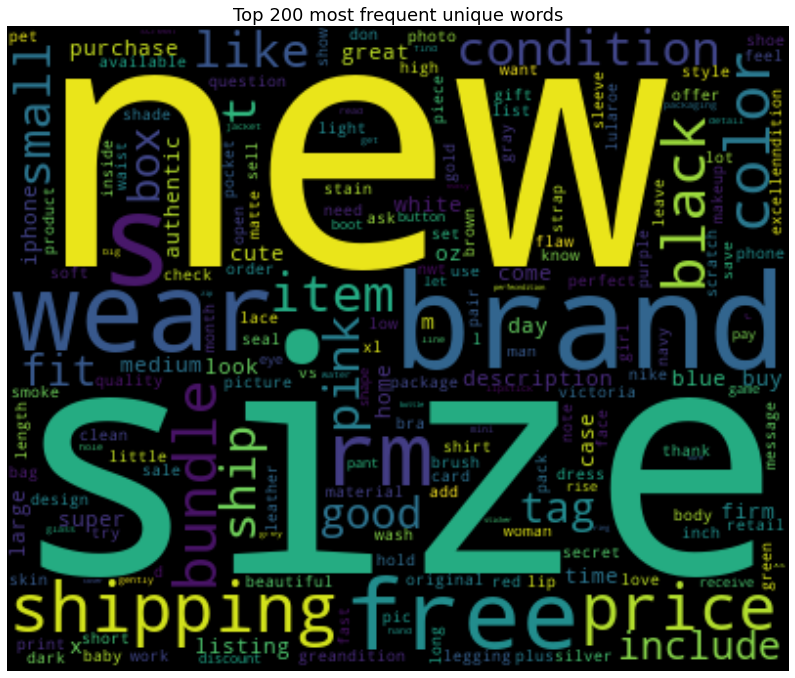

In [ ]:
generate_wordcloud(word_freq)

In [ ]:
data.head()

,train_id,name,item_condition_id,brand_name,price_x_x_x,shipping,item_description,category_main,category_sub1,category_sub2,brand_name_count,"('price', 'mean')_x","('price_y', 'mean')",shipping_count,"('price_x', 'mean')_x",category_main_count,"('price_x_y', 'mean')",category_sub1_count,"('price_x_x', 'mean')_x",category_sub2_count,"('price_x_x_y', 'mean')",word_count,stopword_count,ner,pos,avg_word_len,char_count,num_digit,char_count_without_space,cleaned_item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,uknown,10.0,1,No description yet,Men,Tops,T-shirts,8553,20.537180,26.092650,8948,21.731001,1258,35.191574,318,18.921384,229,17.471616,3,2,0,1,5.333333,18,0,16,description
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3,37.000000,26.092650,11008,29.821403,1610,32.832919,49,71.551020,13,50.153846,36,19,1,14,4.250000,188,0,153,keyboard greandition work like come box port t...
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,22,18.090909,26.136259,8948,21.731001,8895,28.358572,1385,17.555235,279,15.516129,29,18,2,17,3.310345,124,0,96,adorable hint lace key hole pale pink x x avai...
3,3,Leather Horse Statues,1,uknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,8553,20.537180,26.136259,8948,21.731001,846,24.395981,318,22.235849,163,22.429448,32,15,0,17,4.437500,173,0,142,new tag leather horse retail rm stand foot hig...
4,4,24K GOLD plated rose,1,uknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,8553,20.537180,26.136259,11008,29.821403,8895,28.358572,858,25.737762,276,24.449275,5,2,0,4,7.400000,41,0,37,complete certificate authenticity


#### Topic modelling

In [ ]:
%%time
from sklearn.decomposition import LatentDirichletAllocation

# Initialize CountVectorizer
cvectorizer = CountVectorizer(max_features=20000,
                              stop_words='english', 
                              lowercase=True)

# Fit it to our dataset
cvz = cvectorizer.fit_transform(data['cleaned_item_description'])

lda_model = LatentDirichletAllocation(n_components=10, max_iter=20, random_state=20)
X_topics = lda_model.fit_transform(cvz)

n_top_words = 10
topic_summaries = []

# Get the topic words
topic_word = lda_model.components_
# Get the vocabulary from the text features
vocab = cvectorizer.get_feature_names()

# Display the Topic Models
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

Topic 0: lularoe | legging | print | new | lash | unicorn | os | nwt | tc | bnwt
Topic 1: design | easy | light | mm | inch | use | battery | cm | include | high
Topic 2: good | condition | brush | use | bag | black | shape | clean | makeup | authentic
Topic 3: work | include | game | great | come | scratch | book | box | set | picture
Topic 4: size | pink | black | small | fit | wear | new | medium | large | color
Topic 5: iphone | case | plus | phone | apple | cable | new | note | glass | ipad
Topic 6: price | shipping | rm | free | item | bundle | new | ship | description | firm
Topic 7: free | home | smoke | size | blue | pet | baby | bundle | shipping | white
Topic 8: new | size | wear | brand | box | tag | like | time | fit | small
Topic 9: new | oz | brand | rm | color | lip | free | shade | pink | body
CPU times: user 1min 31s, sys: 339 ms, total: 1min 31s
Wall time: 1min 31s


In [ ]:
!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6MB 4.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=46d606e4b28ef0478b912a617034e581094acfaf67783ceca300c92ff5a875d4
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
#nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [ ]:
text_list=data['cleaned_item_description'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

In [ ]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [ ]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [ ]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

#### Feature enginerring 
 * create length features 

In [ ]:
data['word_count_cleaned'] = data['cleaned_item_description'].apply(lambda x: len(x.split()))

In [ ]:
temp = data['word_count_cleaned'].value_counts()
temp.head()

1    1651
5    1093
4    1065
6    1055
7     961
Name: word_count_cleaned, dtype: int64

In [ ]:
data['word_count_cleaned_count'] = data['word_count_cleaned'].apply(lambda x: temp[x])
data[['word_count_cleaned', 'word_count_cleaned_count']].head()

,word_count_cleaned,word_count_cleaned_count
0,1,1651
1,16,457
2,11,746
3,17,396
4,3,943


In [ ]:
data.head()

,train_id,name,item_condition_id,brand_name,price_x_x_x,shipping,item_description,category_main,category_sub1,category_sub2,brand_name_count,"('price', 'mean')_x","('price_y', 'mean')",shipping_count,"('price_x', 'mean')_x",category_main_count,"('price_x_y', 'mean')",category_sub1_count,"('price_x_x', 'mean')_x",category_sub2_count,"('price_x_x_y', 'mean')",word_count,stopword_count,ner,pos,avg_word_len,char_count,num_digit,char_count_without_space,cleaned_item_description,word_count_cleaned,neg,neu,pos,compound,word_count_cleaned_count
0,0,MLB Cincinnati Reds T Shirt Size XL,3,uknown,10.0,1,No description yet,Men,Tops,T-shirts,8553,20.537180,26.092650,8948,21.731001,1258,35.191574,318,18.921384,229,17.471616,3,2,0,1,5.333333,18,0,16,description,1,0.0,1.000,0.000,0.0000,1651
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3,37.000000,26.092650,11008,29.821403,1610,32.832919,49,71.551020,13,50.153846,36,19,1,14,4.250000,188,0,153,keyboard greandition work like come box port t...,16,0.0,0.676,0.324,0.7717,457
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,22,18.090909,26.136259,8948,21.731001,8895,28.358572,1385,17.555235,279,15.516129,29,18,2,17,3.310345,124,0,96,adorable hint lace key hole pale pink x x avai...,11,0.0,0.714,0.286,0.4939,746
3,3,Leather Horse Statues,1,uknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,8553,20.537180,26.136259,8948,21.731001,846,24.395981,318,22.235849,163,22.429448,32,15,0,17,4.437500,173,0,142,new tag leather horse retail rm stand foot hig...,17,0.0,0.829,0.171,0.5106,396
4,4,24K GOLD plated rose,1,uknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,8553,20.537180,26.136259,11008,29.821403,8895,28.358572,858,25.737762,276,24.449275,5,2,0,4,7.400000,41,0,37,complete certificate authenticity,3,0.0,1.000,0.000,0.0000,943


In [ ]:
word_count_cleaned_mean_encoding = data.groupby(['word_count_cleaned']).agg({'price_x_x_x':['mean']}).reset_index()

data = data.merge(word_count_cleaned_mean_encoding,on='word_count_cleaned',how='left')

In [ ]:
data.head()

,train_id,name,item_condition_id,brand_name,price_x_x_x,shipping,item_description,category_main,category_sub1,category_sub2,brand_name_count,"('price', 'mean')_x","('price_y', 'mean')",shipping_count,"('price_x', 'mean')_x",category_main_count,"('price_x_y', 'mean')",category_sub1_count,"('price_x_x', 'mean')_x",category_sub2_count,"('price_x_x_y', 'mean')",word_count,stopword_count,ner,pos,avg_word_len,char_count,num_digit,char_count_without_space,cleaned_item_description,word_count_cleaned,neg,neu,pos,compound,word_count_cleaned_count,"(price_x_x_x, mean)"
0,0,MLB Cincinnati Reds T Shirt Size XL,3,uknown,10.0,1,No description yet,Men,Tops,T-shirts,8553,20.537180,26.092650,8948,21.731001,1258,35.191574,318,18.921384,229,17.471616,3,2,0,1,5.333333,18,0,16,description,1,0.0,1.000,0.000,0.0000,1651,21.959419
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3,37.000000,26.092650,11008,29.821403,1610,32.832919,49,71.551020,13,50.153846,36,19,1,14,4.250000,188,0,153,keyboard greandition work like come box port t...,16,0.0,0.676,0.324,0.7717,457,30.367615
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,22,18.090909,26.136259,8948,21.731001,8895,28.358572,1385,17.555235,279,15.516129,29,18,2,17,3.310345,124,0,96,adorable hint lace key hole pale pink x x avai...,11,0.0,0.714,0.286,0.4939,746,25.438338
3,3,Leather Horse Statues,1,uknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,8553,20.537180,26.136259,8948,21.731001,846,24.395981,318,22.235849,163,22.429448,32,15,0,17,4.437500,173,0,142,new tag leather horse retail rm stand foot hig...,17,0.0,0.829,0.171,0.5106,396,28.085859
4,4,24K GOLD plated rose,1,uknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,8553,20.537180,26.136259,11008,29.821403,8895,28.358572,858,25.737762,276,24.449275,5,2,0,4,7.400000,41,0,37,complete certificate authenticity,3,0.0,1.000,0.000,0.0000,943,22.453871


In [ ]:
data['char_count_cleaned'] = data['cleaned_item_description'].apply(lambda x: len(x))

In [ ]:
temp2 = data['char_count_cleaned'].value_counts()
temp2.head()

11    1260
24     204
14     197
25     194
34     192
Name: char_count_cleaned, dtype: int64

In [ ]:
data['char_count_cleaned_count'] = data['char_count_cleaned'].apply(lambda x: temp2[x])
data[['char_count_cleaned', 'char_count_cleaned_count']].head()

,char_count_cleaned,char_count_cleaned_count
0,11,1260
1,104,68
2,57,126
3,96,83
4,33,173


In [ ]:
char_count_cleaned_mean_encoding = data.groupby(['char_count_cleaned']).agg({'price_x_x_x':['mean']}).reset_index()

data = data.merge(char_count_cleaned_mean_encoding,on='char_count_cleaned',how='left')

In [ ]:
data.head()

,train_id,name,item_condition_id,brand_name,price_x_x_x_x,shipping,item_description,category_main,category_sub1,category_sub2,brand_name_count,"('price', 'mean')_x","('price_y', 'mean')",shipping_count,"('price_x', 'mean')_x",category_main_count,"('price_x_y', 'mean')",category_sub1_count,"('price_x_x', 'mean')_x",category_sub2_count,"('price_x_x_y', 'mean')",word_count,stopword_count,ner,pos,avg_word_len,char_count,num_digit,char_count_without_space,cleaned_item_description,word_count_cleaned,neg,neu,pos,compound,word_count_cleaned_count,"('price_x_x_x', 'mean')_x",char_count_cleaned,char_count_cleaned_count,"(price_x_x_x_y, mean)"
0,0,MLB Cincinnati Reds T Shirt Size XL,3,uknown,10.0,1,No description yet,Men,Tops,T-shirts,8553,20.537180,26.092650,8948,21.731001,1258,35.191574,318,18.921384,229,17.471616,3,2,0,1,5.333333,18,0,16,description,1,0.0,1.000,0.000,0.0000,1651,21.959419,11,1260,22.176984
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3,37.000000,26.092650,11008,29.821403,1610,32.832919,49,71.551020,13,50.153846,36,19,1,14,4.250000,188,0,153,keyboard greandition work like come box port t...,16,0.0,0.676,0.324,0.7717,457,30.367615,104,68,36.161765
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,22,18.090909,26.136259,8948,21.731001,8895,28.358572,1385,17.555235,279,15.516129,29,18,2,17,3.310345,124,0,96,adorable hint lace key hole pale pink x x avai...,11,0.0,0.714,0.286,0.4939,746,25.438338,57,126,28.261905
3,3,Leather Horse Statues,1,uknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,8553,20.537180,26.136259,8948,21.731001,846,24.395981,318,22.235849,163,22.429448,32,15,0,17,4.437500,173,0,142,new tag leather horse retail rm stand foot hig...,17,0.0,0.829,0.171,0.5106,396,28.085859,96,83,28.759036
4,4,24K GOLD plated rose,1,uknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,8553,20.537180,26.136259,11008,29.821403,8895,28.358572,858,25.737762,276,24.449275,5,2,0,4,7.400000,41,0,37,complete certificate authenticity,3,0.0,1.000,0.000,0.0000,943,22.453871,33,173,21.069364


In [ ]:
data['char_count_without_spaces'] = data['cleaned_item_description'].apply(lambda x: len(x.replace(" ","")))

In [ ]:
temp3 = data['char_count_without_spaces'].value_counts()
temp3.head()

11    1328
21     236
26     236
20     220
28     214
Name: char_count_without_spaces, dtype: int64

In [ ]:
data['char_count_without_spaces_count'] = data['char_count_without_spaces'].apply(lambda x: temp3[x])
data[['char_count_without_spaces', 'char_count_without_spaces_count']].head()

,char_count_without_spaces,char_count_without_spaces_count
0,11,1328
1,89,80
2,47,173
3,80,92
4,31,196


In [ ]:
char_count_without_spaces_mean_encoding = data.groupby(['char_count_without_spaces']).agg({'price_x_x_x_x':['mean']}).reset_index()

data = data.merge(char_count_without_spaces_mean_encoding,on='char_count_without_spaces',how='left')

#### Getting sentiment score beased on cleaned_item_description

In [ ]:
c_item_description = data['cleaned_item_description'].to_list()
print(c_item_description[1])

keyboard greandition work like come box port test work perfectly light customizable razer synapse app pc


In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
def nltk_sentiment(sentence):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [ ]:
from tqdm import tqdm
nltk_results = [nltk_sentiment(row) for row in tqdm(c_item_description)]

100%|██████████| 19956/19956 [02:40<00:00, 124.50it/s]


In [ ]:
item_description_sentiment = pd.DataFrame(nltk_results)
item_description_sentiment.head(2)

,neg,neu,pos,compound
0,0.0,1.000,0.000,0.0000
1,0.0,0.676,0.324,0.7717


In [ ]:
item_description_sentiment.shape

(19956, 4)

In [ ]:
data = pd.concat([data, item_description_sentiment], axis=1)
data.head()

,train_id,name,item_condition_id,brand_name,price_x_x_x,shipping,item_description,category_main,category_sub1,category_sub2,brand_name_count,"('price', 'mean')_x","('price_y', 'mean')",shipping_count,"('price_x', 'mean')_x",category_main_count,"('price_x_y', 'mean')",category_sub1_count,"('price_x_x', 'mean')_x",category_sub2_count,"('price_x_x_y', 'mean')",word_count,stopword_count,ner,pos,avg_word_len,char_count,num_digit,char_count_without_space,cleaned_item_description,word_count_cleaned,neg,neu,pos,compound
0,0,MLB Cincinnati Reds T Shirt Size XL,3,uknown,10.0,1,No description yet,Men,Tops,T-shirts,8553,20.537180,26.092650,8948,21.731001,1258,35.191574,318,18.921384,229,17.471616,3,2,0,1,5.333333,18,0,16,description,1,0.0,1.000,0.000,0.0000
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3,37.000000,26.092650,11008,29.821403,1610,32.832919,49,71.551020,13,50.153846,36,19,1,14,4.250000,188,0,153,keyboard greandition work like come box port t...,16,0.0,0.676,0.324,0.7717
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,22,18.090909,26.136259,8948,21.731001,8895,28.358572,1385,17.555235,279,15.516129,29,18,2,17,3.310345,124,0,96,adorable hint lace key hole pale pink x x avai...,11,0.0,0.714,0.286,0.4939
3,3,Leather Horse Statues,1,uknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,8553,20.537180,26.136259,8948,21.731001,846,24.395981,318,22.235849,163,22.429448,32,15,0,17,4.437500,173,0,142,new tag leather horse retail rm stand foot hig...,17,0.0,0.829,0.171,0.5106
4,4,24K GOLD plated rose,1,uknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,8553,20.537180,26.136259,11008,29.821403,8895,28.358572,858,25.737762,276,24.449275,5,2,0,4,7.400000,41,0,37,complete certificate authenticity,3,0.0,1.000,0.000,0.0000


### Creating Bins on wordcount 

In [ ]:
bins=[0,12,19,30,60,90]
group=['child','teenager','young_adult','middle_aged', 'senior_citizen']
stroke_data['word_count_category']=pd.cut(data['word_count'], bins, labels=group)

In [ ]:
stroke_data[['age', 'age_category']].head()

In [ ]:
data.head()

,train_id,name,item_condition_id,brand_name,price_x_x_x_x,shipping,item_description,category_main,category_sub1,category_sub2,brand_name_count,"('price', 'mean')_x","('price_y', 'mean')",shipping_count,"('price_x', 'mean')_x",category_main_count,"('price_x_y', 'mean')",category_sub1_count,"('price_x_x', 'mean')_x",category_sub2_count,"('price_x_x_y', 'mean')",word_count,stopword_count,ner,pos,avg_word_len,char_count,num_digit,char_count_without_space,cleaned_item_description,word_count_cleaned,neg,neu,pos,compound,word_count_cleaned_count,"('price_x_x_x', 'mean')_x",char_count_cleaned,char_count_cleaned_count,"(price_x_x_x_y, mean)",char_count_without_spaces,char_count_without_spaces_count,"(price_x_x_x_x, mean)"
0,0,MLB Cincinnati Reds T Shirt Size XL,3,uknown,10.0,1,No description yet,Men,Tops,T-shirts,8553,20.537180,26.092650,8948,21.731001,1258,35.191574,318,18.921384,229,17.471616,3,2,0,1,5.333333,18,0,16,description,1,0.0,1.000,0.000,0.0000,1651,21.959419,11,1260,22.176984,11,1328,22.088855
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3,37.000000,26.092650,11008,29.821403,1610,32.832919,49,71.551020,13,50.153846,36,19,1,14,4.250000,188,0,153,keyboard greandition work like come box port t...,16,0.0,0.676,0.324,0.7717,457,30.367615,104,68,36.161765,89,80,37.150000
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,22,18.090909,26.136259,8948,21.731001,8895,28.358572,1385,17.555235,279,15.516129,29,18,2,17,3.310345,124,0,96,adorable hint lace key hole pale pink x x avai...,11,0.0,0.714,0.286,0.4939,746,25.438338,57,126,28.261905,47,173,25.930636
3,3,Leather Horse Statues,1,uknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,8553,20.537180,26.136259,8948,21.731001,846,24.395981,318,22.235849,163,22.429448,32,15,0,17,4.437500,173,0,142,new tag leather horse retail rm stand foot hig...,17,0.0,0.829,0.171,0.5106,396,28.085859,96,83,28.759036,80,92,28.820652
4,4,24K GOLD plated rose,1,uknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,8553,20.537180,26.136259,11008,29.821403,8895,28.358572,858,25.737762,276,24.449275,5,2,0,4,7.400000,41,0,37,complete certificate authenticity,3,0.0,1.000,0.000,0.0000,943,22.453871,33,173,21.069364,31,196,25.107143


In [ ]:
data.shape

(19956, 43)

In [ ]:
data.to_csv('p2_train.csv')
!cp p2_train.csv "/content/drive/MyDrive/Mercari/p2_train.csv"